<a href="https://colab.research.google.com/github/SaraAcet/Beslenme.php/blob/main/ba%C4%9Fdokuuu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Gerekli kütüphaneleri yüklüyoruz
import os  # Dosya işlemleri için
import numpy as np  # Sayısal işlemler için
import cv2  # Görüntü işleme için (OpenCV)
import matplotlib.pyplot as plt  # Görüntüleri göstermek için
import tensorflow as tf  # Derin öğrenme kütüphanesi
from tensorflow.keras.models import Sequential  # Sıralı model yapısı
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # CNN katmanları
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Görüntüleri beslemek için
from sklearn.metrics import confusion_matrix, roc_curve, auc  # Model performans ölçümleri
import seaborn as sns  # Karışıklık matrisi görselleştirmesi için
import random  # Rastgele seçimler için
import pandas as pd  # Veri işleme için

# Google Drive'ı Colab'e bağlıyoruz
from google.colab import drive
drive.mount('/content/drive')  # Drive'ı /content/drive yoluna bağlar


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Veri setinin bulunduğu klasörün yolunu tanımlıyoruz
DATASET_PATH = "/content/drive/MyDrive/Bone Scan Images Dataset for Study of Bone Metastases in Adult Breast Cancer Patients at IICS-UNA Paraguay"  # Kendi yoluna göre düzenle

# Sınıf adlarını tanımlıyoruz
classes = ["Bone metastases", "No bone metastases"]  # Metastaz var ve yok
sub_classes = ["Anterior", "Posterior"]  # Ön ve arka görüntüler


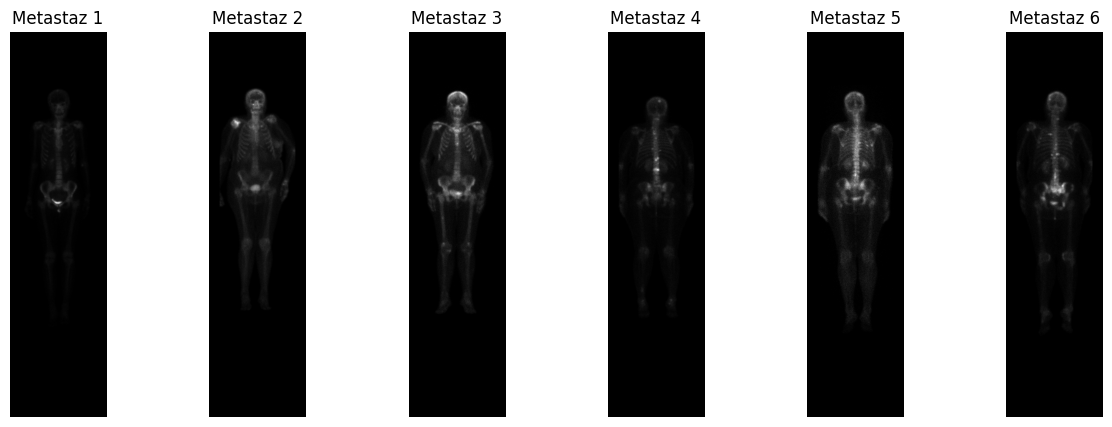

In [ ]:
# 3 tane rastgele metastazlı görüntü seçiyoruz (anterior ve posterior sınıflarından)
metastazli_gorseller = []

for sub_class in sub_classes:
    # Her alt sınıf (ön/arka) için klasör yolunu oluşturuyoruz
    class_path = os.path.join(DATASET_PATH, "Bone metastases", sub_class)

    if os.path.exists(class_path):  # Klasör varsa
        images = os.listdir(class_path)  # İçindeki tüm görselleri al
        random_images = random.sample(images, min(3, len(images)))  # Maksimum 3 tane rastgele seç

        for img in random_images:
            img_path = os.path.join(class_path, img)  # Görselin tam yolu
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Görüntüyü gri tonlamalı olarak oku
            metastazli_gorseller.append((image, img_path))  # Görseli ve yolunu listeye ekle

# Seçilen metastazlı görüntüleri gösteriyoruz
fig, axes = plt.subplots(1, len(metastazli_gorseller), figsize=(15, 5))  # 1 satır, N görsel
for i, (img, path) in enumerate(metastazli_gorseller):
    axes[i].imshow(img, cmap='gray')  # Görseli gri tonla göster
    axes[i].axis('off')  # Eksenleri gizle
    axes[i].set_title(f"Metastaz {i+1}")  # Başlık ekle
plt.show()


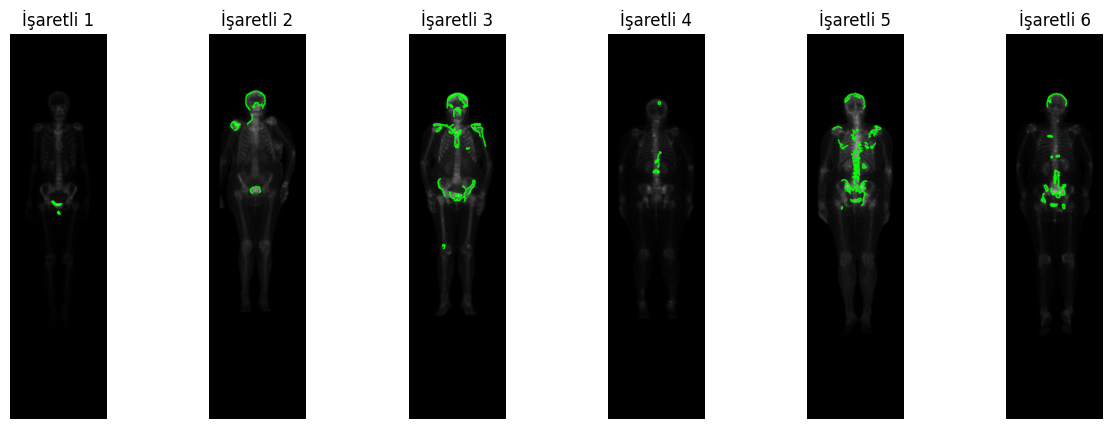

In [ ]:
# Metastaz bölgesini konturla işaretleyen fonksiyon
def metastaz_bolgesini_isaretle(image):
    gray = image.copy()  # Görüntüyü kopyalıyoruz
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Gürültüyü azaltmak için bulanıklaştırma
    edges = cv2.Canny(blurred, 50, 150)  # Kenar tespiti (Canny edge detection)

    # Kenarlardan kontur tespiti yapılıyor
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Görüntüyü renkliye çeviriyoruz (renkli çizim için gerekli)
    image_colored = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

    # Tüm konturları yeşil ile çiziyoruz
    cv2.drawContours(image_colored, contours, -1, (0, 255, 0), 2)

    return image_colored  # Konturlu görüntüyü döndür

# Konturları çizerek gösteriyoruz
fig, axes = plt.subplots(1, len(metastazli_gorseller), figsize=(15, 5))
for i, (img, path) in enumerate(metastazli_gorseller):
    isaretlenmis_gorsel = metastaz_bolgesini_isaretle(img)  # Konturla işaretlenmiş hali
    axes[i].imshow(cv2.cvtColor(isaretlenmis_gorsel, cv2.COLOR_BGR2RGB))  # BGR'den RGB'ye çevir
    axes[i].axis('off')  # Eksenleri gizle
    axes[i].set_title(f"İşaretli {i+1}")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Görüntüleri yüklemek ve normalize etmek için

# Görselleri normalize edip, eğitim ve doğrulama olarak ikiye ayırıyoruz
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # 0-1 aralığına getiriyoruz, %20 doğrulama seti

# Eğitim verisi
train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,                    # Ana veri yolu
    target_size=(224, 224),          # Görsellerin yeniden boyutlandırılması
    batch_size=32,                   # Aynı anda işleyeceğimiz görüntü sayısı
    class_mode="binary",             # İkili sınıflandırma (0 veya 1)
    subset="training"                # Eğitim için
)

# Doğrulama verisi
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,                    # Ana veri yolu
    target_size=(224, 224),          # Aynı boyut
    batch_size=32,                   # Aynı batch boyutu
    class_mode="binary",             # Yine ikili sınıflandırma
    subset="validation"              # Doğrulama için
)


Found 466 images belonging to 2 classes.
Found 116 images belonging to 2 classes.


In [ ]:
# CNN modeli tanımlıyoruz (özellik çıkarımı ve sınıflandırma için)
model = Sequential([

    # 1. Konvolüsyon katmanı: 32 filtre, 3x3 çekirdek boyutu, aktivasyon fonksiyonu: ReLU
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2,2)),  # Maksimum havuzlama: boyutu küçültür, önemli özellikleri korur

    # 2. Konvolüsyon katmanı: 64 filtre
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    # 3. Konvolüsyon katmanı: 128 filtre
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),  # Tüm filtre çıktılarını tek boyuta indirir

    Dense(128, activation='relu'),  # Tam bağlantılı katman
    Dropout(0.5),  # Aşırı öğrenmeyi önlemek için %50 dropout
    Dense(1, activation='sigmoid')  # Son katman: 0 veya 1 çıkışı (binary sınıflandırma)
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Modeli derliyoruz
model.compile(
    optimizer='adam',  # Adam optimizasyon algoritması (etkili ve yaygın)
    loss='binary_crossentropy',  # İkili sınıflandırma için uygun kayıp fonksiyonu
    metrics=['accuracy']  # Doğruluk oranı ile modeli değerlendireceğiz
)

# Modeli eğitiyoruz
model.fit(
    train_generator,                # Eğitim verisi
    validation_data=val_generator, # Doğrulama verisi
    epochs=10                       # Eğitim döngüsü sayısı
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 63s 4s/step - accuracy: 0.7724 - loss: 1.3764 - val_accuracy: 0.7931 - val_loss: 0.5185
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.7852 - loss: 0.5101 - val_accuracy: 0.7931 - val_loss: 0.5575
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8141 - loss: 0.4552 - val_accuracy: 0.7931 - val_loss: 0.5277
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.8055 - loss: 0.4340 - val_accuracy: 0.7931 - val_loss: 0.5263
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.7931 - loss: 0.4516 - val_accuracy: 0.7931 - val_loss: 0.5347
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7716 - loss: 0.4546 - val_accuracy: 0.7845 - val_loss: 0.5533
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 4s/step - accuracy: 0.7860 - loss: 0.4403 - val_accuracy: 0.7931 - val_loss: 0.6151
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 81s 4s/step - accuracy: 0.8040 - loss: 0.4559 - val_accuracy: 0.7586 - val_loss:

In [ ]:
# Shuffle=False olacak şekilde yeniden oluşturuyoruz
val_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    subset="validation",
    shuffle=False  # Tahminlerin sıralı olması için shuffle kapatılır
)


Found 116 images belonging to 2 classes.


In [ ]:
# Gerçek etiketler
y_true = val_generator.classes  # Doğrulama verisinin sınıf etiketleri

# Modelin tahminleri
y_pred_prob = model.predict(val_generator)  # Sigmoid çıktıları (olasılıklar)
y_pred = (y_pred_prob > 0.5).astype(int)    # 0.5'ten büyükse 1 (yani metastaz), değilse 0


3/4 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step


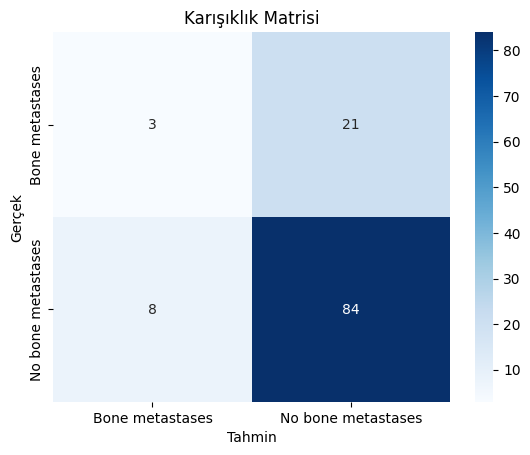

In [ ]:
# Karışıklık matrisi hesaplama
conf_matrix = confusion_matrix(y_true, y_pred)

# Görselleştirme
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Karışıklık Matrisi")  # Başlık
plt.xlabel("Tahmin")             # X ekseni: modelin tahmini
plt.ylabel("Gerçek")             # Y ekseni: gerçek değer
plt.show()


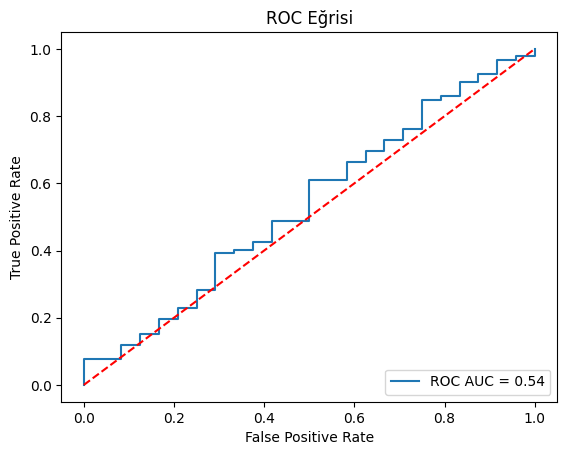

In [ ]:
# ROC eğrisi için False Positive Rate (fpr), True Positive Rate (tpr) hesaplama
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)  # AUC skoru (0-1 arasında, 1 en iyi)

# ROC eğrisini çiziyoruz
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.2f}")  # AUC değerini göster
plt.plot([0, 1], [0, 1], "r--")  # Referans çizgisi (random classifier)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi")
plt.legend(loc="lower right")
plt.show()


In [ ]:
"""

# Modelin bir kez çağrılmış olması gerekir, bu nedenle örnek bir tahmin yapıyoruz
_ = model.predict(img_array)
"""


# Önce görüntüyü al, yeniden boyutlandır ve normalize et
img_gray = metastazli_gorseller[0][0]  # İlk metastazlı görseli al
img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)  # Griden RGB'ye çevir
img_resized = cv2.resize(img_rgb, (224, 224))  # Model boyutuna getir
img_array = np.expand_dims(img_resized, axis=0) / 255.0  # Batch ve normalize

# Modelin bir kez çağrılmış olması gerekir, bu nedenle örnek bir tahmin yapıyoruz
_ = model.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step


In [ ]:
"""


import tensorflow.keras.backend as K  # Model içindeki ara katmanlara ulaşmak için

# Grad-CAM hesaplama fonksiyonu
def grad_cam(model, img_array, layer_name):


   # model: Eğitilmiş model
    #img_array: (1, H, W, 3) boyutlu giriş görseli
    #layer_name: Çıkış haritasını alacağımız katmanın adı


    # Modelin son sınıflandırma katmanından önceki hedef katmanı alıyoruz
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Binary sınıflandırmada sadece 0. sınıfı kullanıyoruz

    # Gradyanları alıyoruz
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Ortalama gradyan

    conv_outputs = conv_outputs[0]  # (H, W, Channels)
    heatmap = np.zeros(conv_outputs.shape[:2], dtype=np.float32)

    # Kanal bazında ağırlıklı toplam
    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]

    # Relu ile negatifleri sıfırla, normalize et
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1

    return heatmap



######
import tensorflow.keras.backend as K

# Grad-CAM fonksiyonu: Modelin dikkat ettiği bölgeleri gösterir
def grad_cam(model, img_array, layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]  # İlgili katman ve çıkış alınır
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)  # Aktivasyon ve tahminler
        loss = predictions[:, 0]  # Binary sınıflandırmada pozitif sınıfın çıktısı

    grads = tape.gradient(loss, conv_outputs)  # Gradyanlar hesaplanır
    pooled_grads = K.mean(grads, axis=(0, 1, 2))  # Ortalama alınır (her kanal için)

    conv_outputs = conv_outputs[0]  # 4D'den 3D'ye geçiyoruz (tek görüntü)
    heatmap = np.zeros(shape=conv_outputs.shape[:2], dtype=np.float32)

    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]  # Kanal bazlı çarpma

    heatmap = np.maximum(heatmap, 0)  # Relu: negatifleri sıfırla
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Normalize et

    return heatmap
"""



import tensorflow.keras.backend as K

def grad_cam(model, img_array, layer_name="conv2d_2"):
    """
    Grad-CAM çıktısını döndürür.
    """
    # 1. Modelin ilgili katmanını ve çıktısını alan mini model oluşturuluyor
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    # 2. Gradient hesaplaması
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)  # Grad-CAM gradyanları
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Kanal ortalaması

    conv_outputs = conv_outputs[0]  # Sıkıştır (batch boyutu çıkar)
    heatmap = tf.zeros(conv_outputs.shape[:2], dtype=tf.float32)

    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]

    heatmap = tf.nn.relu(heatmap)  # Negatifleri sıfırla
    heatmap /= tf.reduce_max(heatmap) + 1e-10  # Normalize et

    return heatmap.numpy()  # NumPy olarak döndür



In [ ]:
"""
def apply_heatmap(original_img, heatmap, alpha=0.4):


    #original_img: Orijinal görsel (224x224x3)
    #heatmap: Grad-CAM çıktısı (224x224)
    #alpha: Saydamlık seviyesi

    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))  # Görsel boyutuna getir
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)   # Renkli heatmap oluştur
    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)     # Üst üste bindir
    return overlay


    """

def apply_heatmap(original_img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay



In [ ]:
"""


# Önce görüntüyü al, yeniden boyutlandır ve normalize et
img_rgb = cv2.cvtColor(metastazli_gorseller[0][0], cv2.COLOR_GRAY2RGB)  # Griden RGB'ye çevir
img_resized = cv2.resize(img_rgb, (224, 224))  # Model boyutuna getir
img_array = np.expand_dims(img_resized, axis=0) / 255.0  # Batch ve normalize

# Grad-CAM heatmap hesapla (son konvolüsyon katmanı adı genelde "conv2d_2" olur)
heatmap = grad_cam(model, img_array, layer_name="conv2d_2")

# Isı haritasını görüntünün üstüne bindir
heatmap_img = apply_heatmap(img_resized, heatmap)

# Göster
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_resized)
plt.title("Orijinal Görsel")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(heatmap_img)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()
"""

"""
def grad_cam(model, img_array, layer_name="conv2d_2"):

    #Grad-CAM çıktısını döndürür.

    # Model çağrılmamışsa çağır!
    _ = model(img_array)  # <-- BU ŞART

    # Grad-CAM için modelin ara katmanı ve çıkışı alınır
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.zeros(conv_outputs.shape[:2], dtype=tf.float32)

    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]

    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap) + 1e-10

    return heatmap.numpy()
"""



def grad_cam(model, img_array, layer_name="conv2d_2"):
    """
    Grad-CAM çıktısını döndürür. Sequential model için özel destek içerir.
    """
    # MODELİN ÇAĞRILMASI ŞART – bu olmazsa hata alırsın!
    model(img_array)  # Bu satır olmadan Sequential modellerde .output tanımsız olur

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.zeros(conv_outputs.shape[:2], dtype=tf.float32)

    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]

    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap) + 1e-10

    return heatmap.numpy()


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,507,269 (127.82 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 22,338,180 (85.21 MB)

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Giriş katmanı
inputs = Input(shape=(224, 224, 3))

# Konvolüsyon katmanları
x = Conv2D(32, (3,3), activation='relu', name='conv2d_0')(inputs)
x = MaxPooling2D((2,2))(x)

x = Conv2D(64, (3,3), activation='relu', name='conv2d_1')(x)
x = MaxPooling2D((2,2))(x)

x = Conv2D(128, (3,3), activation='relu', name='conv2d_2')(x)  # 🔥 Bunu Grad-CAM'de kullanacağız
x = MaxPooling2D((2,2))(x)

# Düzleştir ve çıktı katmanları
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Modeli oluştur
model = Model(inputs, outputs)


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=val_generator, epochs=10)


Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step - accuracy: 0.7301 - loss: 1.6784 - val_accuracy: 0.7931 - val_loss: 0.5194
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.8047 - loss: 0.4815 - val_accuracy: 0.7931 - val_loss: 0.5129
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7973 - loss: 0.4851 - val_accuracy: 0.7931 - val_loss: 0.5169
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 53s 4s/step - accuracy: 0.7852 - loss: 0.4911 - val_accuracy: 0.7931 - val_loss: 0.5388
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7932 - loss: 0.4759 - val_accuracy: 0.7931 - val_loss: 0.5266
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 55s 4s/step - accuracy: 0.7856 - loss: 0.4811 - val_accuracy: 0.7931 - val_loss: 0.5233
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 80s 4s/step - accuracy: 0.8029 - loss: 0.4298 - val_accuracy: 0.7931 - val_loss: 0.5339
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.8314 - loss: 0.3924 - val_accuracy: 0.7586 - val_loss:

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_43']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


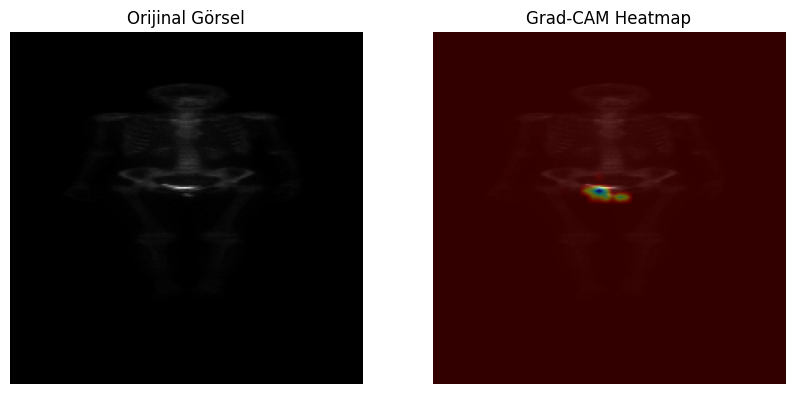

In [ ]:
# Görseli hazırla
img_gray = metastazli_gorseller[0][0]
img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))
img_array = np.expand_dims(img_resized, axis=0) / 255.0

# Grad-CAM üret (içeride model çağrılıyor)
heatmap = grad_cam(model, img_array, layer_name="conv2d_2")


# Görsel üzerine bindir
heatmap_img = apply_heatmap(img_resized, heatmap)

# Göster
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_resized)
plt.title("Orijinal Görsel")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(heatmap_img)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()


In [ ]:
print(model.input)
print(model.output)


<KerasTensor shape=(None, 224, 224, 3), dtype=float32, sparse=False, name=keras_tensor_43>
<KerasTensor shape=(None, 1), dtype=float32, sparse=False, name=keras_tensor_53>


In [ ]:
def bag_doku_hasari_analiz_et(image, path=None, eşik1=0.05, eşik2=0.10):
    """
    Görüntüdeki metastaz yayılımını analiz eder ve hasar + komplikasyon bilgisi döndürür.
    """
    gray = image.copy()  # Gri görüntü
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)  # Gürültüyü azalt
    edges = cv2.Canny(blurred, 50, 150)  # Kenar tespiti

    # Kenarlardan hesaplanan metastaz "yayılım oranı"
    metastaz_orani = np.sum(edges > 0) / (image.shape[0] * image.shape[1])

    # Karar ağaçları gibi eşiklere göre analiz yapılıyor
    if metastaz_orani > eşik2:
        hasar = "Yüksek"
        komplikasyon = "Omurilik basısı, kırık riski"
    elif metastaz_orani > eşik1:
        hasar = "Orta"
        komplikasyon = "Şiddetli ağrı, hareket kısıtlılığı"
    else:
        hasar = "Düşük"
        komplikasyon = "Hafif ağrı"

    # Eğer yol bilgisi varsa çıktı olarak yazdır
    if path:
        print(f"Görüntü: {os.path.basename(path)} - Hasar: {hasar}, Komplikasyon: {komplikasyon}")

    return hasar, komplikasyon


In [ ]:
# 3 örnek metastazlı görselin analizini yapıyoruz
for img, path in metastazli_gorseller:
    hasar, komplikasyon = bag_doku_hasari_analiz_et(img, path)


Görüntü: A19.png - Hasar: Düşük, Komplikasyon: Hafif ağrı
Görüntü: A59.png - Hasar: Düşük, Komplikasyon: Hafif ağrı
Görüntü: A12.png - Hasar: Düşük, Komplikasyon: Hafif ağrı
Görüntü: P26.png - Hasar: Düşük, Komplikasyon: Hafif ağrı
Görüntü: P50.png - Hasar: Düşük, Komplikasyon: Hafif ağrı
Görüntü: P55.png - Hasar: Düşük, Komplikasyon: Hafif ağrı


In [ ]:
# CSV raporu için liste topla
rapor_listesi = []

for img, path in metastazli_gorseller:
    hasar, komplikasyon = bag_doku_hasari_analiz_et(img)
    rapor_listesi.append({
        "Görüntü": os.path.basename(path),
        "Hasar Derecesi": hasar,
        "Komplikasyon": komplikasyon
    })

# Pandas ile tablo oluştur ve CSV olarak kaydet
rapor_df = pd.DataFrame(rapor_listesi)
rapor_df.to_csv("/content/metastaz_komplikasyon_raporu.csv", index=False)
print("Rapor oluşturuldu: /content/metastaz_komplikasyon_raporu.csv")


Rapor oluşturuldu: /content/metastaz_komplikasyon_raporu.csv


In [ ]:
# Örnek vaka kayıtları
vaka_verisi = [
    {"Hasar Derecesi": "Yüksek", "Komplikasyon": "Omurilik basısı", "Tedavi": "Radyoterapi + Cerrahi stabilizasyon"},
    {"Hasar Derecesi": "Orta", "Komplikasyon": "Hareket kısıtlılığı", "Tedavi": "Analjezik + Kemoterapi"},
    {"Hasar Derecesi": "Düşük", "Komplikasyon": "Hafif ağrı", "Tedavi": "İzlem + Hafif fizik tedavi"},
    {"Hasar Derecesi": "Yüksek", "Komplikasyon": "Kırık riski", "Tedavi": "Ortopedik müdahale + Radyoterapi"},
    {"Hasar Derecesi": "Orta", "Komplikasyon": "Şiddetli ağrı", "Tedavi": "Bifosfonat + Ağrı yönetimi"},
]

# DataFrame olarak oluştur
tedavi_df = pd.DataFrame(vaka_verisi)

# Gözle görelim
display(tedavi_df)


,Hasar Derecesi,Komplikasyon,Tedavi
0,Yüksek,Omurilik basısı,Radyoterapi + Cerrahi stabilizasyon
1,Orta,Hareket kısıtlılığı,Analjezik + Kemoterapi
2,Düşük,Hafif ağrı,İzlem + Hafif fizik tedavi
3,Yüksek,Kırık riski,Ortopedik müdahale + Radyoterapi
4,Orta,Şiddetli ağrı,Bifosfonat + Ağrı yönetimi


In [ ]:
def tedavi_oner(hasar, komplikasyon, tedavi_df):
    """
    Hasar + komplikasyona göre önerilen tedaviyi döndürür.
    """
    # İlk olarak hem hasar hem komplikasyon eşleşen kayıtları ara
    eslesenler = tedavi_df[
        (tedavi_df["Hasar Derecesi"] == hasar) &
        (tedavi_df["Komplikasyon"].str.contains(komplikasyon.split(",")[0]))
    ]

    if not eslesenler.empty:
        return eslesenler["Tedavi"].values[0]
    else:
        # Hasara göre genel bir öneri yap
        genel = tedavi_df[tedavi_df["Hasar Derecesi"] == hasar]
        if not genel.empty:
            return genel["Tedavi"].values[0]
        else:
            return "Veriye uygun öneri bulunamadı."

# Örnek kullanım: ilk görüntü üzerinden
ornek_img = metastazli_gorseller[0][0]
hasar, komplikasyon = bag_doku_hasari_analiz_et(ornek_img)

# Tedavi önerisi al
onerilen = tedavi_oner(hasar, komplikasyon, tedavi_df)
print(f"Önerilen Tedavi: {onerilen}")


Önerilen Tedavi: İzlem + Hafif fizik tedavi


In [ ]:
# Yeni rapor: Görsel, Hasar, Komplikasyon, Tedavi
rapor_listesi = []

for img, path in metastazli_gorseller:
    hasar, komplikasyon = bag_doku_hasari_analiz_et(img)
    tedavi = tedavi_oner(hasar, komplikasyon, tedavi_df)
    rapor_listesi.append({
        "Görüntü": os.path.basename(path),
        "Hasar Derecesi": hasar,
        "Komplikasyon": komplikasyon,
        "Önerilen Tedavi": tedavi
    })

# DataFrame ve CSV
rapor_df = pd.DataFrame(rapor_listesi)
rapor_df.to_csv("/content/drive/MyDrive/metastaz_raporu_tedavi_ile.csv", index=False)
print("Genişletilmiş rapor oluşturuldu: /content/drive/MyDrive/metastaz_raporu_tedavi_ile.csv")


Genişletilmiş rapor oluşturuldu: /content/drive/MyDrive/metastaz_raporu_tedavi_ile.csv


In [ ]:
# Sadece sağlıklı (no metastaz) görselleri yüklüyoruz
def load_healthy_images(base_path, sub_classes, limit_per_class=100):
    images = []
    for sub in sub_classes:
        path = os.path.join(base_path, "No bone metastases", sub)
        if os.path.exists(path):
            for img_name in os.listdir(path)[:limit_per_class]:
                img_path = os.path.join(path, img_name)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (128, 128))
                images.append(img / 255.0)
    return np.array(images)

healthy_images = load_healthy_images(DATASET_PATH, sub_classes)
healthy_images = healthy_images.reshape((-1, 128, 128, 1))  # Autoencoder için boyutlandır
print("Sağlıklı görüntü sayısı:", healthy_images.shape[0])


Sağlıklı görüntü sayısı: 200


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

input_img = Input(shape=(128, 128, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Modeli oluştur
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(healthy_images, healthy_images,
                epochs=20, batch_size=32,
                shuffle=True, validation_split=0.2)


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 0.6732 - val_loss: 0.5602
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.4917 - val_loss: 0.3938
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.3183 - val_loss: 0.2973
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.2235 - val_loss: 0.1718
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.1508 - val_loss: 0.1318
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.1180 - val_loss: 0.1254
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 0.1188 - val_loss: 0.1224
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.1123 - val_loss: 0.1231
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - loss: 0.1140 - val_loss: 0.1222
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - loss: 0.1133 - val_loss: 0.1209
Epoch 11/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.1104 - val_loss: 0.1196
Epoch 12/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.1076 - val_loss: 0.1186
Epoch 13/20
5/

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Rekonstrüksiyon Hatası (MSE): 0.00033687682516637106


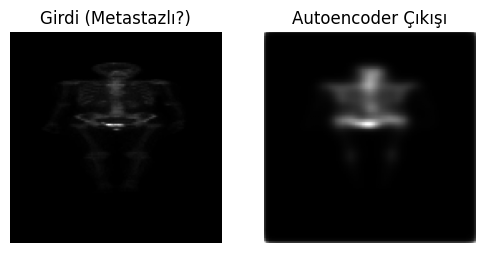

In [ ]:
# 1 rastgele metastazlı görüntü alalım
test_img = metastazli_gorseller[0][0]
test_img_resized = cv2.resize(test_img, (128, 128)) / 255.0
test_img_input = test_img_resized.reshape(1, 128, 128, 1)

# Modelin tahmini (rekonstrüksiyon)
reconstructed = autoencoder.predict(test_img_input)

# Rekonstrüksiyon hatası
mse = np.mean((test_img_input - reconstructed) ** 2)
print("Rekonstrüksiyon Hatası (MSE):", mse)

# Görsel olarak karşılaştır
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(test_img_resized, cmap='gray')
plt.title("Girdi (Metastazlı?)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed[0].reshape(128, 128), cmap='gray')
plt.title("Autoencoder Çıkışı")
plt.axis('off')
plt.show()


In [ ]:
!pip install fpdf
from fpdf import FPDF
import tempfile
from PIL import Image


In [ ]:
"""


def rapor_olustur_pdf(gorsel, heatmap, hasar, komplikasyon, tedavi, mse_skoru, dosya_adi="rapor.pdf"):

    #Görsel ve analiz çıktıları ile PDF raporu oluşturur.

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    # Başlık
    pdf.set_font("Arial", 'B', size=16)
    pdf.cell(200, 10, txt="METASTAZ ANALİZ RAPORU", ln=True, align='C')
    pdf.set_font("Arial", size=12)
    pdf.ln(10)



    # Metin Bilgileri
    pdf.cell(200, 10, f"Hasar Derecesi: {hasar}", ln=True)
    pdf.cell(200, 10, f"Komplikasyon: {komplikasyon}", ln=True)
    pdf.cell(200, 10, f"Önerilen Tedavi: {tedavi}", ln=True)
    pdf.cell(200, 10, f"Autoencoder Anomali Skoru (MSE): {mse_skoru:.5f}", ln=True)
    pdf.ln(10)

    # Görselleri geçici olarak kaydet, sonra PDF'e ekle
    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp1:
        cv2.imwrite(tmp1.name, cv2.cvtColor(gorsel, cv2.COLOR_RGB2BGR))
        pdf.image(tmp1.name, x=10, y=80, w=90, h=90)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp2:
        cv2.imwrite(tmp2.name, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
        pdf.image(tmp2.name, x=110, y=80, w=90, h=90)

    pdf.output(dosya_adi)
    print(f"PDF raporu oluşturuldu: {dosya_adi}")
"""



def rapor_olustur_pdf(gorsel, heatmap, hasar, komplikasyon, tedavi, mse_skoru, dosya_adi="rapor.pdf"):
    from fpdf import FPDF
    import tempfile
    import cv2

    def temizle(metin):
        return metin.translate(str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU"))

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.set_font("Arial", 'B', size=16)
    pdf.cell(200, 10, txt="METASTAZ ANALIZ RAPORU", ln=True, align='C')
    pdf.set_font("Arial", size=12)
    pdf.ln(10)

    pdf.cell(200, 10, temizle(f"Hasar Derecesi: {hasar}"), ln=True)
    pdf.cell(200, 10, temizle(f"Komplikasyon: {komplikasyon}"), ln=True)
    pdf.cell(200, 10, temizle(f"Onerilen Tedavi: {tedavi}"), ln=True)
    pdf.cell(200, 10, f"Anomali Skoru (MSE): {mse_skoru:.5f}", ln=True)

    # Görselleri geçici kaydet ve ekle
    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp1:
        cv2.imwrite(tmp1.name, cv2.cvtColor(gorsel, cv2.COLOR_RGB2BGR))
        pdf.image(tmp1.name, x=10, y=80, w=90, h=90)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp2:
        cv2.imwrite(tmp2.name, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
        pdf.image(tmp2.name, x=110, y=80, w=90, h=90)

    pdf.output(dosya_adi)
    print(f"PDF raporu oluşturuldu: {dosya_adi}")


In [ ]:
# Orijinal gri görseli al ve RGB’ye çevir
img_gray = metastazli_gorseller[0][0]
img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
img_resized = cv2.resize(img_rgb, (224, 224))
img_array = np.expand_dims(img_resized, axis=0) / 255.0

# Grad-CAM üret
heatmap_map = grad_cam(model, img_array, layer_name="conv2d_2")
heatmap_img = apply_heatmap(img_resized, heatmap_map)

# Komplikasyon analizi
hasar, komplikasyon = bag_doku_hasari_analiz_et(img_gray)

# Tedavi önerisi
tedavi = tedavi_oner(hasar, komplikasyon, tedavi_df)

# Anomali tespiti
img_auto = cv2.resize(img_gray, (128, 128)) / 255.0
img_auto = img_auto.reshape(1, 128, 128, 1)
reconstructed = autoencoder.predict(img_auto)
mse = np.mean((img_auto - reconstructed) ** 2)
def temizle(metin):
    return metin.translate(str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU"))


# Raporu oluştur
rapor_olustur_pdf(
    gorsel=img_resized,
    heatmap=heatmap_img,
    hasar=hasar,
    komplikasyon=komplikasyon,
    tedavi=tedavi,
    mse_skoru=mse,
    dosya_adi="/content/drive/MyDrive/metastaz_gorsel_raporu.pdf"
        #dosya_adi="/content/metastaz_gorsel_raporu.pdf"

)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_43']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
PDF raporu oluşturuldu: /content/drive/MyDrive/metastaz_gorsel_raporu.pdf


In [ ]:
"""import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np

# GUI ana pencere
pencere = tk.Tk()
pencere.title("Metastaz Görüntü Analizi")
pencere.geometry("600x400")

# Görseli yükle
def goruntu_sec():
    dosya_yolu = filedialog.askopenfilename()
    if not dosya_yolu:
        return

    global secilen_gorsel
    secilen_gorsel = dosya_yolu

    img = Image.open(dosya_yolu)
    img.thumbnail((250, 250))
    img_tk = ImageTk.PhotoImage(img)
    panel.configure(image=img_tk)
    panel.image = img_tk
    sec_btn.configure(state="normal")

# Yer tutucu görsel paneli
panel = tk.Label(pencere)
panel.pack(pady=20)

# Görsel seçme butonu
btn = tk.Button(pencere, text="Görsel Seç", command=goruntu_sec)
btn.pack()

# Analiz butonu (şimdilik boş)
def analiz_et():
    messagebox.showinfo("Analiz", "Analiz fonksiyonu buraya entegre edilecek.")

sec_btn = tk.Button(pencere, text="Analizi Başlat", command=analiz_et, state="disabled")
sec_btn.pack(pady=10)

# Pencereyi çalıştır
pencere.mainloop()
"""

'import tkinter as tk\nfrom tkinter import filedialog, messagebox\nfrom PIL import Image, ImageTk\nimport cv2\nimport numpy as np\n\n# GUI ana pencere\npencere = tk.Tk()\npencere.title("Metastaz Görüntü Analizi")\npencere.geometry("600x400")\n\n# Görseli yükle\ndef goruntu_sec():\n    dosya_yolu = filedialog.askopenfilename()\n    if not dosya_yolu:\n        return\n\n    global secilen_gorsel\n    secilen_gorsel = dosya_yolu\n\n    img = Image.open(dosya_yolu)\n    img.thumbnail((250, 250))\n    img_tk = ImageTk.PhotoImage(img)\n    panel.configure(image=img_tk)\n    panel.image = img_tk\n    sec_btn.configure(state="normal")\n\n# Yer tutucu görsel paneli\npanel = tk.Label(pencere)\npanel.pack(pady=20)\n\n# Görsel seçme butonu\nbtn = tk.Button(pencere, text="Görsel Seç", command=goruntu_sec)\nbtn.pack()\n\n# Analiz butonu (şimdilik boş)\ndef analiz_et():\n    messagebox.showinfo("Analiz", "Analiz fonksiyonu buraya entegre edilecek.")\n\nsec_btn = tk.Button(pencere, text="Analizi Başla

In [ ]:
!pip install gradio


In [ ]:
import gradio as gr
import cv2
import numpy as np
from PIL import Image

def analiz_et_gradio(girdi_gorsel):
    # Görseli OpenCV formatına çevir
    img_rgb = np.array(girdi_gorsel.convert("RGB"))
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    # Grad-CAM üret
    heatmap_map = grad_cam(model, img_array, layer_name="conv2d_2")
    heatmap_img = apply_heatmap(img_resized, heatmap_map)

    # Komplikasyon ve tedavi
    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    hasar, komplikasyon = bag_doku_hasari_analiz_et(img_gray)
    tedavi = tedavi_oner(hasar, komplikasyon, tedavi_df)

    # Anomali skoru
    img_auto = cv2.resize(img_gray, (128, 128)) / 255.0
    img_auto = img_auto.reshape(1, 128, 128, 1)
    reconstructed = autoencoder.predict(img_auto)
    mse = np.mean((img_auto - reconstructed) ** 2)

    # PDF üret
    dosya_adi = "/content/metastaz_raporu_gradio.pdf"
    rapor_olustur_pdf(
        gorsel=img_resized,
        heatmap=heatmap_img,
        hasar=hasar,
        komplikasyon=komplikasyon,
        tedavi=tedavi,
        mse_skoru=mse,
        dosya_adi=dosya_adi
    )

    return heatmap_img, dosya_adi


In [ ]:
gr.Interface(
    fn=analiz_et_gradio,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Image(label="Grad-CAM Heatmap"),
        gr.File(label="PDF Rapor")
    ],
    title="Metastaz Görüntü Analizi",
    description="Görseli yükle, sistem otomatik analiz yapsın ve PDF rapor oluştursun."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c776d570bb42be874b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
def analiz_et_gradio(girdi_gorsel, hasta_adi, tarih, notlar):
    img_rgb = np.array(girdi_gorsel.convert("RGB"))
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    heatmap_map = grad_cam(model, img_array, layer_name="conv2d_2")
    heatmap_img = apply_heatmap(img_resized, heatmap_map)

    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    hasar, komplikasyon = bag_doku_hasari_analiz_et(img_gray)
    tedavi = tedavi_oner(hasar, komplikasyon, tedavi_df)

    img_auto = cv2.resize(img_gray, (128, 128)) / 255.0
    img_auto = img_auto.reshape(1, 128, 128, 1)
    reconstructed = autoencoder.predict(img_auto)
    mse = np.mean((img_auto - reconstructed) ** 2)

    # Dosya adı hasta adına göre
    pdf_yolu = f"/content/{hasta_adi.replace(' ', '_')}_raporu.pdf"

    # PDF'e ek olarak: hasta adı ve notları da ekle
    rapor_olustur_pdf(
        gorsel=img_resized,
        heatmap=heatmap_img,
        hasar=hasar,
        komplikasyon=komplikasyon,
        tedavi=tedavi,
        mse_skoru=mse,
        dosya_adi=pdf_yolu,
        hasta_adi=hasta_adi,
        tarih=tarih,
        notlar=notlar
    )

    return heatmap_img, pdf_yolu


In [ ]:
def rapor_olustur_pdf(gorsel, heatmap, hasar, komplikasyon, tedavi, mse_skoru, dosya_adi,
                      hasta_adi="", tarih="", notlar=""):
    from fpdf import FPDF
    import tempfile

    def temizle(metin):
        return metin.translate(str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU"))

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.set_font("Arial", 'B', 16)
    pdf.cell(200, 10, txt="METASTAZ ANALIZ RAPORU", ln=True, align='C')
    pdf.set_font("Arial", size=12)
    pdf.ln(5)

    pdf.cell(200, 10, temizle(f"Hasta Adi: {hasta_adi}"), ln=True)
    pdf.cell(200, 10, temizle(f"Tarih: {tarih}"), ln=True)
    pdf.cell(200, 10, temizle(f"Not: {notlar}"), ln=True)
    pdf.ln(5)

    pdf.cell(200, 10, temizle(f"Hasar Derecesi: {hasar}"), ln=True)
    pdf.cell(200, 10, temizle(f"Komplikasyon: {komplikasyon}"), ln=True)
    pdf.cell(200, 10, temizle(f"Onerilen Tedavi: {tedavi}"), ln=True)
    pdf.cell(200, 10, f"Anomali Skoru (MSE): {mse_skoru:.5f}", ln=True)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp1:
        cv2.imwrite(tmp1.name, cv2.cvtColor(gorsel, cv2.COLOR_RGB2BGR))
        pdf.image(tmp1.name, x=10, y=100, w=90, h=90)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp2:
        cv2.imwrite(tmp2.name, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
        pdf.image(tmp2.name, x=110, y=100, w=90, h=90)

    pdf.output(dosya_adi)


In [ ]:
gr.Interface(
    fn=analiz_et_gradio,
    inputs=[
        gr.Image(type="pil", label="Görüntü Yükle"),
        gr.Textbox(label="Hasta Adı"),
        gr.Textbox(label="Tarih (GG/AA/YYYY)"),
        gr.Textbox(label="Notlar / Klinik Yorum")
    ],
    outputs=[
        gr.Image(label="Grad-CAM"),
        gr.File(label="PDF Rapor")
    ],
    title="Metastaz Görsel Analizi Web Arayüzü",
    description="Görseli yükle, klinik bilgileri gir, PDF analiz raporu oluştur."
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://b37f8b2c7b984123c7.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# GEREKLİ KÜTÜPHANELER
import gradio as gr
import cv2
import numpy as np
from PIL import Image
from fpdf import FPDF
import tempfile

# ÖRNEK VERİ SETİ: Tedavi önerileri için simülasyon
import pandas as pd
tedavi_df = pd.DataFrame([
    {"Hasar Derecesi": "Yuksek", "Komplikasyon": "Omurilik basisi", "Tedavi": "Radyoterapi + Cerrahi stabilizasyon"},
    {"Hasar Derecesi": "Orta", "Komplikasyon": "Hareket kisitliligi", "Tedavi": "Analjezik + Kemoterapi"},
    {"Hasar Derecesi": "Dusuk", "Komplikasyon": "Hafif agri", "Tedavi": "Izlem + Hafif fizik tedavi"},
    {"Hasar Derecesi": "Yuksek", "Komplikasyon": "Kirık riski", "Tedavi": "Ortopedik mudahale + Radyoterapi"},
    {"Hasar Derecesi": "Orta", "Komplikasyon": "Siddetli agri", "Tedavi": "Bifosfonat + Agri yonetimi"},
])

# GRAD-CAM fonksiyonu (örnek versiyon, model bağımlı çalışmalı)
def grad_cam(model, img_array, layer_name="conv2d_2"):
    model(img_array)  # çağrılma garantisi
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.zeros(conv_outputs.shape[:2], dtype=tf.float32)
    for i in range(pooled_grads.shape[0]):
        heatmap += pooled_grads[i] * conv_outputs[:, :, i]
    heatmap = tf.nn.relu(heatmap)
    heatmap /= tf.reduce_max(heatmap) + 1e-10
    return heatmap.numpy()

def apply_heatmap(original_img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def bag_doku_hasari_analiz_et(image):
    gray = image.copy()
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    oran = np.sum(edges > 0) / (image.shape[0] * image.shape[1])
    if oran > 0.10:
        return "Yuksek", "Omurilik basisi, kirik riski"
    elif oran > 0.05:
        return "Orta", "Siddetli agri, hareket kisitliligi"
    else:
        return "Dusuk", "Hafif agri"

def tedavi_oner(hasar, komplikasyon, tedavi_df):
    eslesen = tedavi_df[(tedavi_df["Hasar Derecesi"] == hasar)]
    if not eslesen.empty:
        return eslesen.iloc[0]["Tedavi"]
    else:
        return "Veriye uygun tedavi bulunamadi."

def rapor_olustur_pdf(gorsel, heatmap, hasar, komplikasyon, tedavi, mse_skoru, dosya_adi, hasta_adi="", tarih="", notlar=""):
    def temizle(metin):
        return metin.translate(str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU"))

    pdf = FPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=12)

    pdf.set_font("Arial", 'B', 16)
    pdf.cell(200, 10, txt="METASTAZ ANALIZ RAPORU", ln=True, align='C')
    pdf.set_font("Arial", size=12)
    pdf.ln(5)

    pdf.cell(200, 10, temizle(f"Hasta Adi: {hasta_adi}"), ln=True)
    pdf.cell(200, 10, temizle(f"Tarih: {tarih}"), ln=True)
    pdf.cell(200, 10, temizle(f"Not: {notlar}"), ln=True)
    pdf.ln(5)

    pdf.cell(200, 10, temizle(f"Hasar Derecesi: {hasar}"), ln=True)
    pdf.cell(200, 10, temizle(f"Komplikasyon: {komplikasyon}"), ln=True)
    pdf.cell(200, 10, temizle(f"Onerilen Tedavi: {tedavi}"), ln=True)
    pdf.cell(200, 10, f"Anomali Skoru (MSE): {mse_skoru:.5f}", ln=True)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp1:
        cv2.imwrite(tmp1.name, cv2.cvtColor(gorsel, cv2.COLOR_RGB2BGR))
        pdf.image(tmp1.name, x=10, y=100, w=90, h=90)

    with tempfile.NamedTemporaryFile(delete=False, suffix=".png") as tmp2:
        cv2.imwrite(tmp2.name, cv2.cvtColor(heatmap, cv2.COLOR_RGB2BGR))
        pdf.image(tmp2.name, x=110, y=100, w=90, h=90)

    pdf.output(dosya_adi)

def analiz_et_gradio(girdi_gorsel, hasta_adi, tarih, notlar):
    img_rgb = np.array(girdi_gorsel.convert("RGB"))
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_array = np.expand_dims(img_resized, axis=0) / 255.0

    heatmap_map = grad_cam(model, img_array, layer_name="conv2d_2")
    heatmap_img = apply_heatmap(img_resized, heatmap_map)

    img_gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
    hasar, komplikasyon = bag_doku_hasari_analiz_et(img_gray)
    tedavi = tedavi_oner(hasar, komplikasyon, tedavi_df)

    img_auto = cv2.resize(img_gray, (128, 128)) / 255.0
    img_auto = img_auto.reshape(1, 128, 128, 1)
    reconstructed = autoencoder.predict(img_auto)
    mse = np.mean((img_auto - reconstructed) ** 2)

    pdf_yolu = f"/content/{hasta_adi.replace(' ', '_')}_raporu.pdf"

    rapor_olustur_pdf(
        gorsel=img_resized,
        heatmap=heatmap_img,
        hasar=hasar,
        komplikasyon=komplikasyon,
        tedavi=tedavi,
        mse_skoru=mse,
        dosya_adi=pdf_yolu,
        hasta_adi=hasta_adi,
        tarih=tarih,
        notlar=notlar
    )

    return heatmap_img, pdf_yolu

gr.Interface(
    fn=analiz_et_gradio,
    inputs=[
        gr.Image(type="pil", label="Gorsel Yükle"),
        gr.Textbox(label="Hasta Adi"),
        gr.Textbox(label="Tarih (GG/AA/YYYY)"),
        gr.Textbox(label="Notlar / Klinik Gözlem")
    ],
    outputs=[
        gr.Image(label="Grad-CAM Sonucu"),
        gr.File(label="PDF Rapor")
    ],
    title="Metastaz Tespiti Arayüzü",
    description="Görüntü analizi + Tedavi önerisi + Anomali tespiti + PDF çıktısı"
).launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://97108b638ba3c4f153.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
